# Neste Trabalho vamos criar um preditor de preços com regressões lineares.

Ele não tem a intenção de ser um trabalho completo ou um estudo sobre a elasticide-preço, apenas uma introdução que passa por diversos problemas comuns nesse tipo de estudo e algumas possíveis soluções a esses problemas.

O trabalho é melhor executado em um jupyter notebook com python 3.6

In [1]:
# !pip install pandas
# !pip install numpy
# !pip install sklearn
# !pip install matplotlib
# !pip install scipy
# !pip install statsmodels
# !pip install keras
# !pip install pysal
# !pip install geopandas
# !pip install mplleaflet

In [2]:
# Math, stat and data
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf

# sklearn for regressions
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

# keras for deep learning
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

# packages for geopatial regressions
# import pysal as ps
# import geopandas as gpd
# 

# packages for viz
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import mplleaflet as mpll

%matplotlib inline

Using TensorFlow backend.


In [3]:
path = 'C:\\Users\\ABC\\OneDrive\\data\\pricing_predict\\data\\house_sales.csv'
# path = '/Users/sn3fru/OneDrive/data/pricing_predict/data/house_sales.csv'
# path = 'house_sales.csv'

# 1) Analise exploratória

#### Antes de mais nada vamos dar uma boa olhada no comportamento das distribuições cruzadas com a função pairplot do seaborn, com isso consigo ter uma boa ideia de quais variaveis são fortes candidatos a serem tratadas, quais tem alta correlação e quais são boas candidatas para dummies

In [4]:
df = pd.read_csv(path)

In [5]:
df.head(10)

price  num_bed  num_bath  size_house  size_lot  num_floors  \
0   221900        3      1.00        1180      5650         1.0   
1   538000        3      2.25        2570      7242         2.0   
2   180000        2      1.00         770     10000         1.0   
3   604000        4      3.00        1960      5000         1.0   
4   510000        3      2.00        1680      8080         1.0   
5  1225000        4      4.50        5420    101930         1.0   
6   257500        3      2.25        1715      6819         2.0   
7   229500        3      1.00        1780      7470         1.0   
8   323000        3      2.50        1890      6560         2.0   
9   662500        3      2.50        3560      9796         1.0   

   is_waterfront  condition  size_basement  year_built  renovation_date  \
0              0          3              0        1955                0   
1              0          3            400        1951             1991   
2              0          3              0        1933                0   
3              0          5            910        1965                0   
4              0          3              0        1987                0   
5              0          3           1530        2001                0   
6              0          3              0        1995                0   
7              0          3            730        1960                0   
8              0          3              0        2003                0   
9              0          3           1700        1965                0   

     zip   latitude   longitude  avg_size_neighbor_houses  \
0  98178  47.511234 -122.256775                      1340   
1  98125  47.721023 -122.318862                      1690   
2  98028  47.737927 -122.233196                      2720   
3  98136  47.520820 -122.393185                      1360   
4  98074  47.616812 -122.044901                      1800   
5  98053  47.656118 -122.005287                      4760   
6  98003  47.309720 -122.327049                      2238   
7  98146  47.512294 -122.336595                      1780   
8  98038  47.368407 -122.030818                      2390   
9  98007  47.600660 -122.145296                      2210   

   avg_size_neighbor_lot  
0                   5650  
1                   7639  
2                   8062  
3                   5000  
4                   7503  
5                 101930  
6                   6819  
7                   8113  
8                   7570  
9                   8925

In [6]:
df.describe()

price       num_bed      num_bath    size_house      size_lot  \
count  1.844800e+04  18448.000000  18448.000000  18448.000000  1.844800e+04   
mean   5.423624e+05      3.372615      2.118888   2083.940915  1.503602e+04   
std    3.720135e+05      0.933892      0.772384    921.416218  4.181455e+04   
min    7.800000e+04      0.000000      0.000000    290.000000  5.200000e+02   
25%    3.218375e+05      3.000000      1.750000   1430.000000  5.050000e+03   
50%    4.500000e+05      3.000000      2.250000   1920.000000  7.600500e+03   
75%    6.480000e+05      4.000000      2.500000   2560.000000  1.062525e+04   
max    7.700000e+06     33.000000      8.000000  13540.000000  1.651359e+06   

         num_floors  is_waterfront     condition  size_basement    year_built  \
count  18448.000000   18448.000000  18448.000000   18448.000000  18448.000000   
mean       1.494606       0.007643      3.411698     293.571498   1971.001138   
std        0.540806       0.087092      0.652593     443.607503     29.361619   
min        1.000000       0.000000      1.000000       0.000000   1900.000000   
25%        1.000000       0.000000      3.000000       0.000000   1952.000000   
50%        1.500000       0.000000      3.000000       0.000000   1975.000000   
75%        2.000000       0.000000      4.000000     570.000000   1997.000000   
max        3.500000       1.000000      5.000000    4820.000000   2015.000000   

       renovation_date           zip      latitude     longitude  \
count     18448.000000  18448.000000  18448.000000  18448.000000   
mean         85.145002  98077.921455     47.560030   -122.214419   
std         403.371263     53.497440      0.138557      0.139910   
min           0.000000  98001.000000     47.155933   -122.518648   
25%           0.000000  98033.000000     47.471527   -122.328084   
50%           0.000000  98065.000000     47.571599   -122.230688   
75%           0.000000  98118.000000     47.677918   -122.125733   
max        2015.000000  98199.000000     47.777624   -121.315254   

       avg_size_neighbor_houses  avg_size_neighbor_lot  
count              18448.000000           18448.000000  
mean                1988.306483           12571.596216  
std                  686.173124           26329.260211  
min                  399.000000             651.000000  
25%                 1490.000000            5100.000000  
50%                 1840.000000            7611.000000  
75%                 2370.000000           10050.000000  
max                 6110.000000          858132.000000

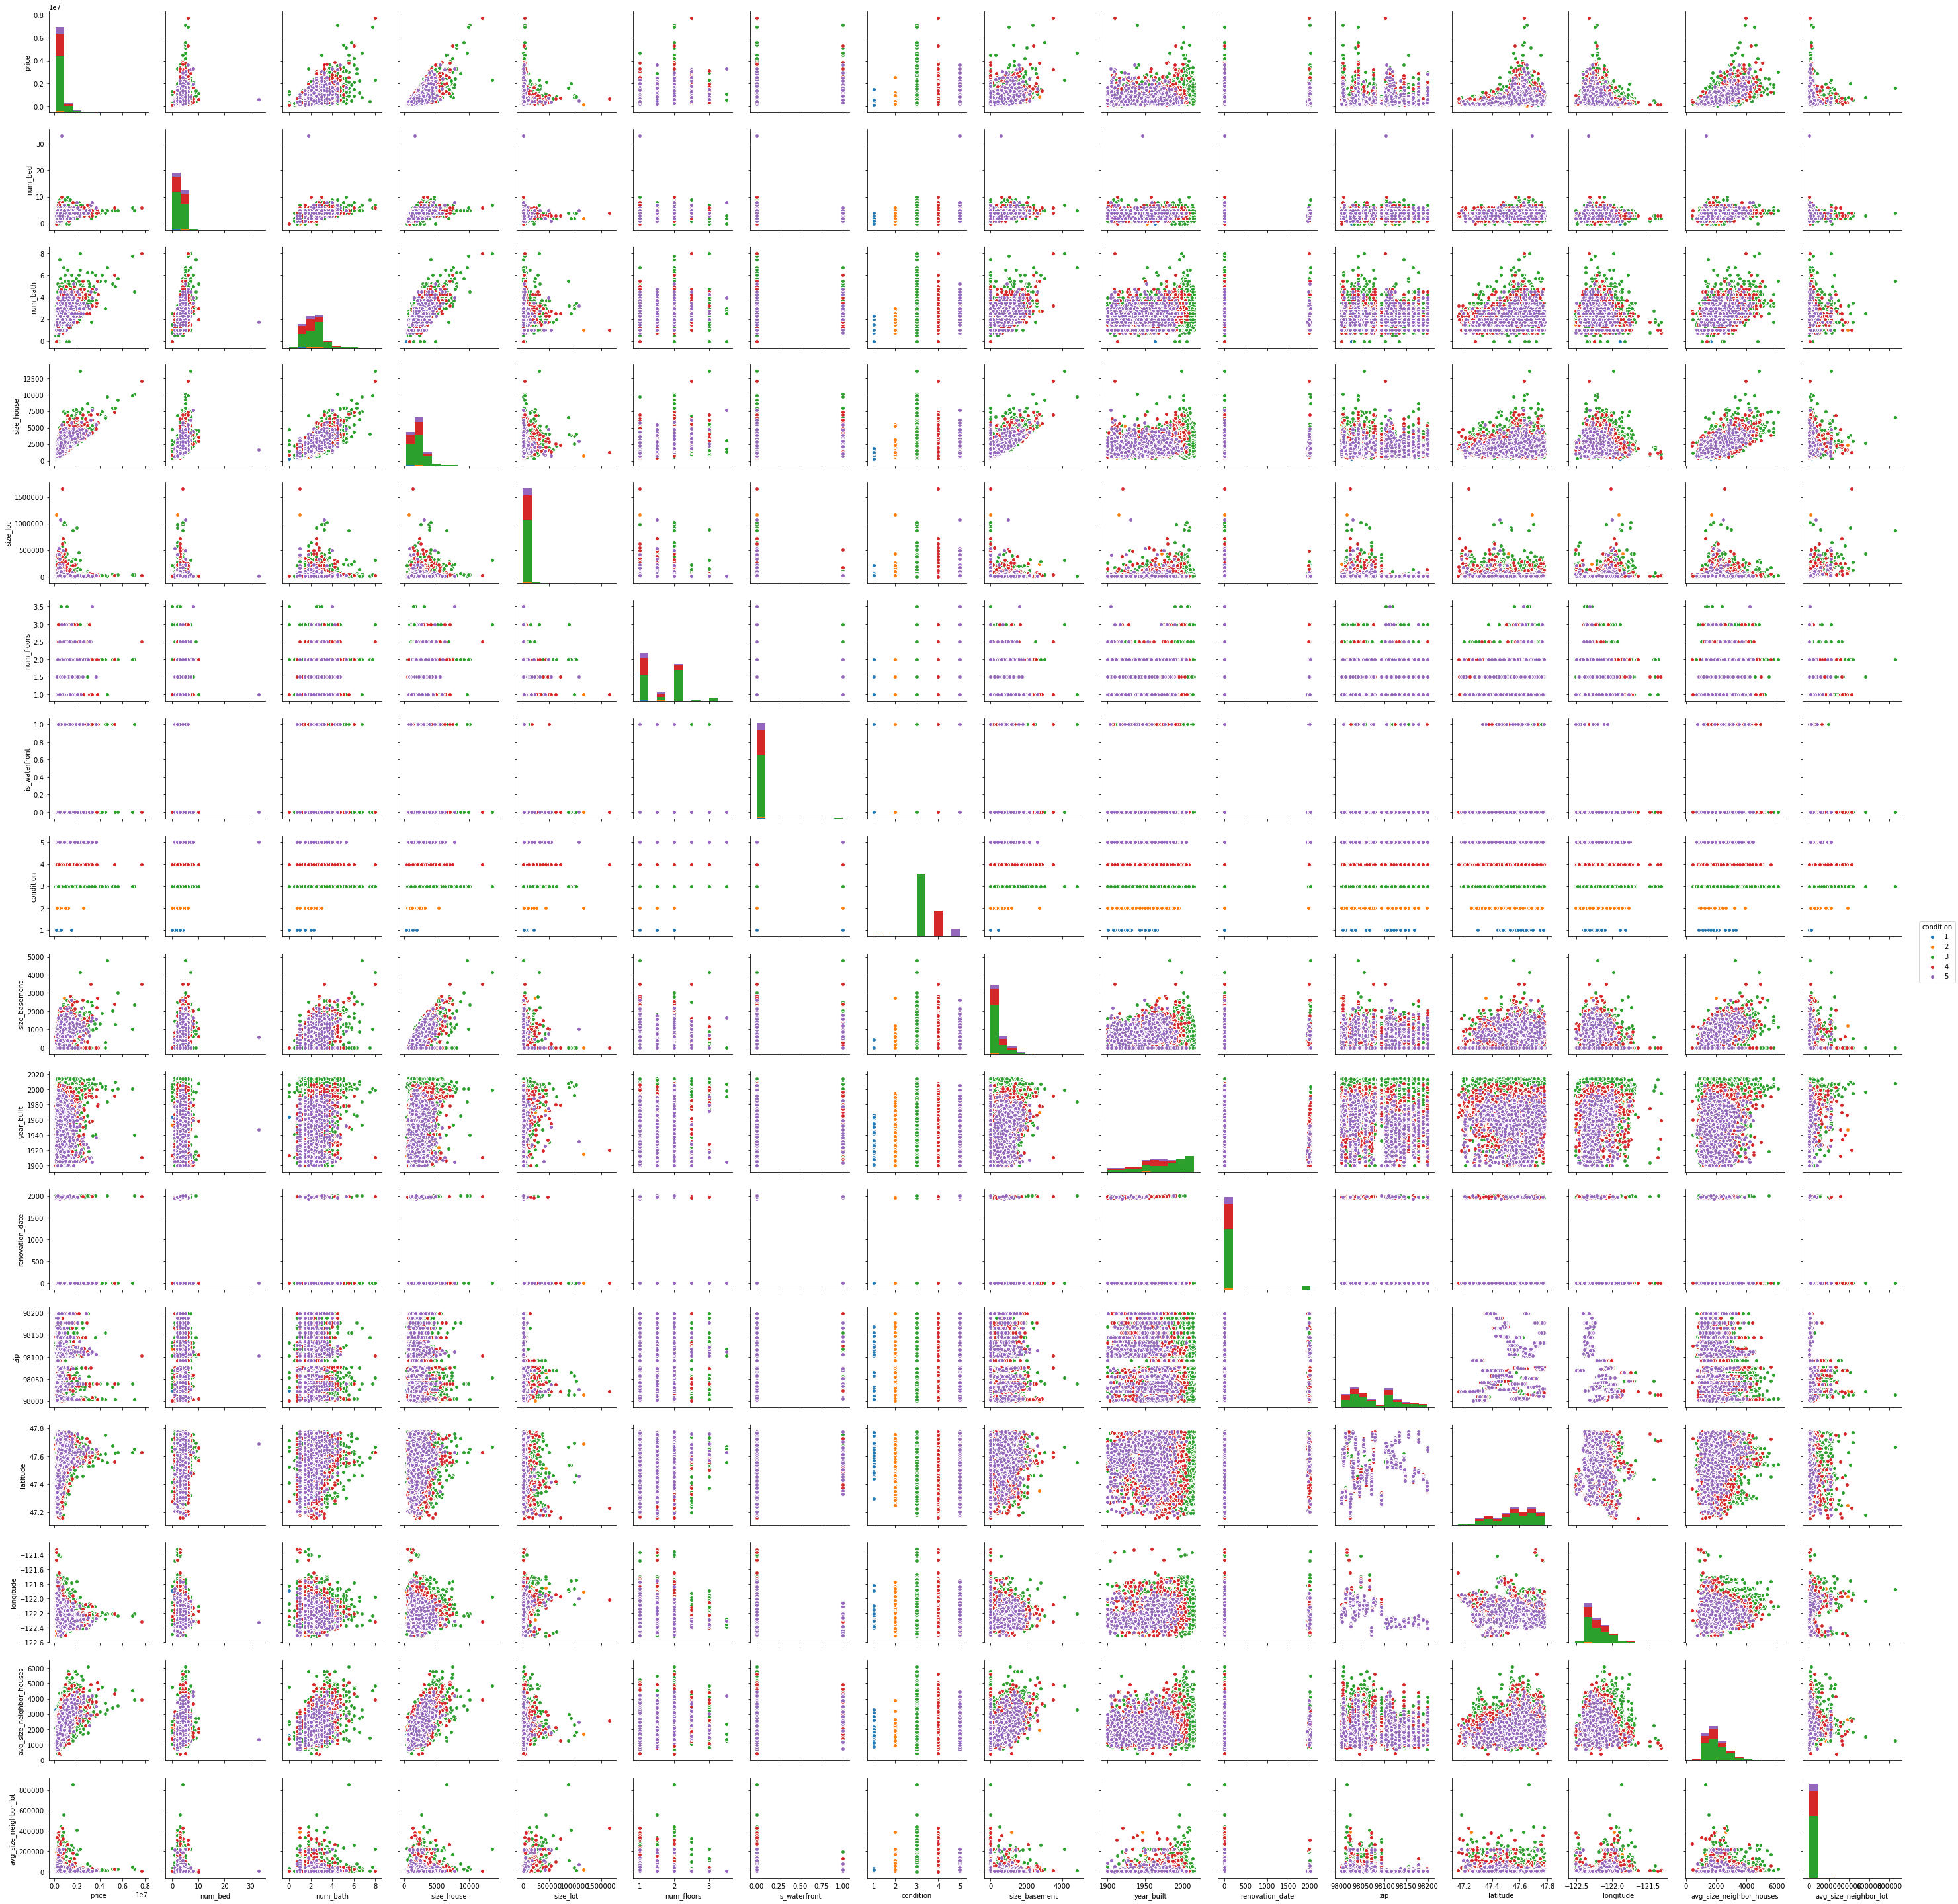

In [7]:
g = sns.pairplot(df, hue="condition")
# g.savefig('first-pairplot')

### temos mais variaveis do que eu imaginava para fazer isso no olho, vamos ver como é a correlação geral dessas variaveis ...

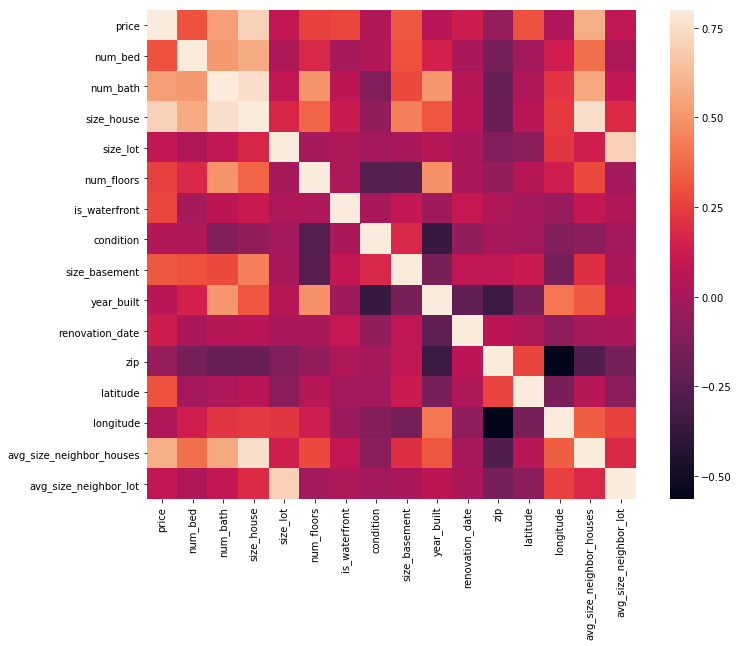

In [8]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

### Parece que muitas variaveis tem baixa correlação com as demais (pelo menos sem fazer algum tratamento) com isso vamos plotar apenas as 10 variaveis com maiores correlações com o preço.

Estranho notar a latitude e longitude sendo sendo bastante correlacionado, isso só faria sentido se a amostra for toda de uma pequena região onde haveria um gradiente de preços. Se Fosse todo os EUA, esse feito linear se anularia.

Vamos ver.

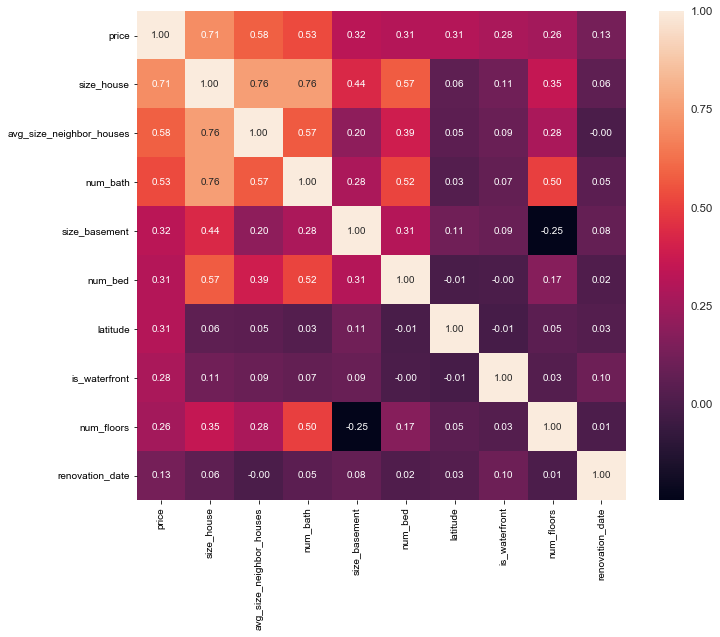

In [9]:
k = 10
f, ax = plt.subplots(figsize=(12, 9))
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.15)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

### Checamos que a base não tem valores nulos: (mas tem muitos valores zero onde deveria ser nulo)

In [10]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total  Percent
avg_size_neighbor_lot         0      0.0
avg_size_neighbor_houses      0      0.0
longitude                     0      0.0
latitude                      0      0.0
zip                           0      0.0
renovation_date               0      0.0
year_built                    0      0.0
size_basement                 0      0.0
condition                     0      0.0
is_waterfront                 0      0.0
num_floors                    0      0.0
size_lot                      0      0.0
size_house                    0      0.0
num_bath                      0      0.0
num_bed                       0      0.0
price                         0      0.0

In [11]:
### checamos quais as variaveis são muito assimétricas:
numeric_feats = df.dtypes[df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df[numeric_feats].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



Skew
size_lot                  13.396166
is_waterfront             11.306838
avg_size_neighbor_lot      9.059845
renovation_date            4.526556
price                      4.115432
num_bed                    2.216423
size_basement              1.570224
size_house                 1.502484
avg_size_neighbor_houses   1.100440
condition                  1.022991

### Uma breve olhada nos dados geograficos fornecidos já nos dizem muito sobre as possibilidades dessa base.

Se tivessemos uma amostra de todo os EUA, não faria muito sentido usar autocorrelação espacial já que os efeitos são dissipados rápidamente, mas como estamos falando de uma area razoavelmente pequena, um único distrito, King County (em Washington), podemos não só usar as autocorrelações espaciais, como podemos usar os dados públicos como o censu americano ( https://www.census.gov ) e até dados de GIS (https://gis-kingcounty.opendata.arcgis.com/) para enriquecer nosso preditor de preços de venda.



In [12]:
points = np.arange(df.shape[0])
np.random.shuffle(points)
f, ax = plt.subplots(1, figsize=(9, 9))
df.iloc[points[:500], :].plot(kind='scatter', x='longitude',
                             y='latitude',s=30, linewidth=0, ax=ax);
mpll.display(fig=f,)

### mapa plotado no Tableau Public, os números nas regiões representam a quantidade unidades vendidas e a intensidade das cores é o preço médio das unidades conforme escala abaixo

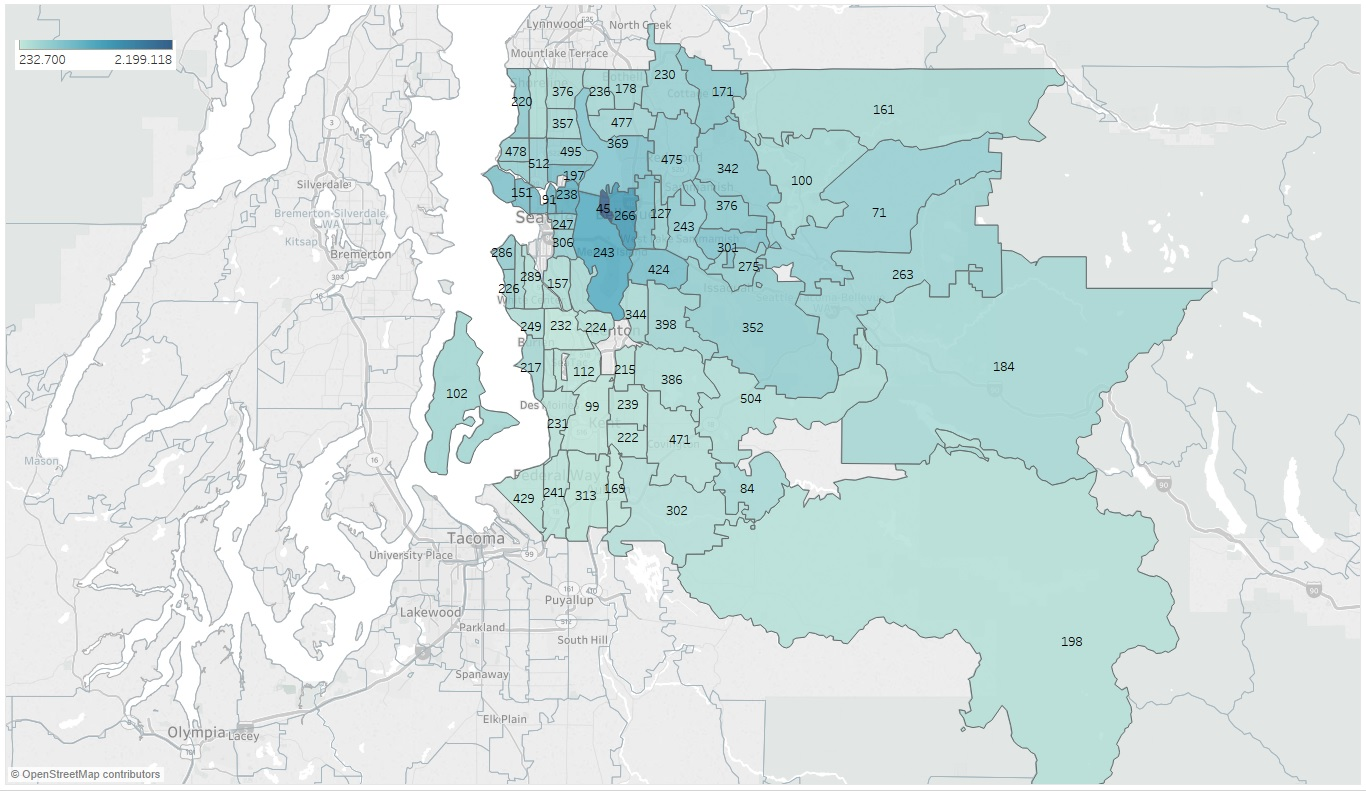

In [13]:
Image(filename='C:\\Users\\ABC\\Desktop\\tableau-map.jpg') 

### Por último vamos rodar uma simples regressão nos dados sem tratamento para ver como as variaveis se comportam ceteris paribus, ou seja, o valor dos betas, seus sinais e suas significancias estatisticas.

Tem muita coisa para se analisar na regressão abaixo, mas vamos falar só do genérico e deixar para as próximas com variaveis tratadas.

Temos o um R2 de 0.577 com muita assimetria e curtose elevada indicando residuos mal distribuidos.

In [14]:
function1 = '''
price ~ num_bed
 + num_bath
 + size_house
 + size_lot
 + num_floors
 + is_waterfront
 + condition
 + size_basement
 + renovation_date
 + avg_size_neighbor_houses
 + avg_size_neighbor_lot
 + zip
'''

model1 = smf.ols(function1, df).fit()
print(model1.summary2())

                                 Results: Ordinary least squares
Model:                        OLS                        Adj. R-squared:               0.577      
Dependent Variable:           price                      AIC:                          509732.5226
Date:                         2017-08-27 21:01           BIC:                          509834.2178
No. Observations:             18448                      Log-Likelihood:               -2.5485e+05
Df Model:                     12                         F-statistic:                  2101.      
Df Residuals:                 18435                      Prob (F-statistic):           0.00       
R-squared:                    0.578                      Scale:                        5.8494e+10 
--------------------------------------------------------------------------------------------------
                             Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
--------------------------------------------

# 2) Engenharia de Variaveis

A maior, mais díficil e mais importante etapa.

### Embora os dados exibam um comportamento linear, a amostra é bastante heterocedastica.

Analisando o primeiro pairplor, notamos séries 'explosivas', para torna-la homocedastica podemos aplicar diversas técnicas, usaremos o mais simples que é a aplicação de log nas duas variaveis pois além deconseguimos a variância constante, temos uma interpretação de elasticidade (taxa de variação) para os parâmetros.


Abaixo a relação entre Preços e o tamanho da casa que imaginamos que tenha uma forte e positiva correlação.

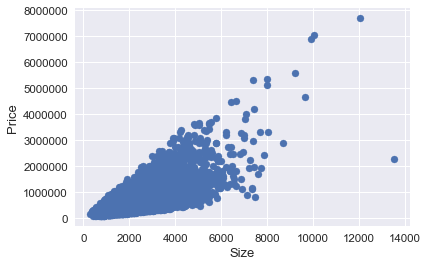

In [15]:
fig, ax = plt.subplots()
ax.scatter(x = df['size_house'], y = df['price'])
plt.ylabel('Price', fontsize=13)
plt.xlabel('Size', fontsize=13)
plt.show()

#### Descreverei como log-linearizaremos' as principais variaveis com mais detalhes e as demais será feito o procedimento (se necessário) sem explicações

Não necessáriamente precisamos ter distribuições normais para nossas amostras, mas ela ter essa caracteristica permite que façamos analises não só mais eficientes mas principalmente mais robustas já que a maioria dos algoritmos de regressões que usaremos trazem betas significativos para qualquer distribuição apenas com o primeiro momento, mas não somos capazes de fazer testes de hipótese sem o segundo momento.

C:\Users\ABC\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j



 mu = 542362.37 and sigma = 372003.44



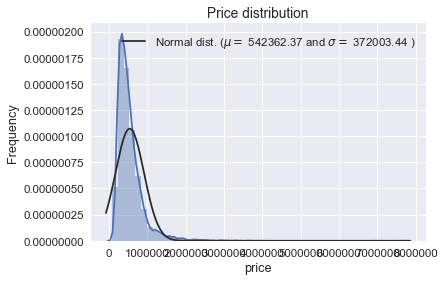

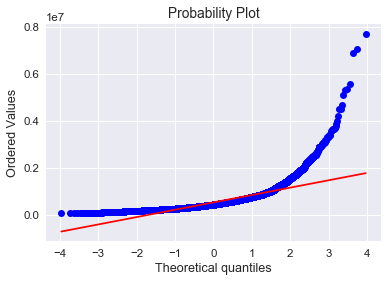

In [16]:
sns.distplot(df['price'] , fit=stats.norm);

(mu, sigma) = stats.norm.fit(df['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

fig = plt.figure()
res = stats.probplot(df['price'], plot=plt)
plt.show()

#### E após a aplicação de logaritmo natural na variavel ...

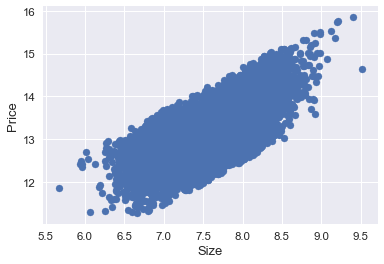

C:\Users\ABC\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j



 mu = 13.05 and sigma = 0.53



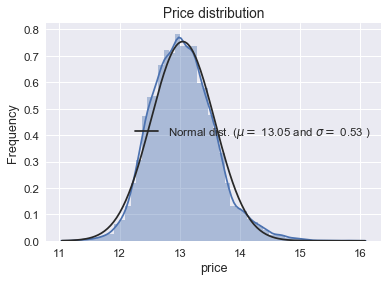

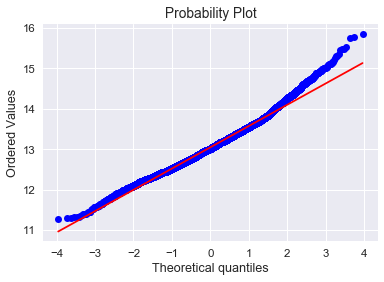

In [17]:
fig, ax = plt.subplots()
ax.scatter(x = np.log(df['size_house']), y = np.log(df['price']))
plt.ylabel('Price', fontsize=13)
plt.xlabel('Size', fontsize=13)
plt.show()


sns.distplot(np.log(df['price']) , fit=stats.norm);

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(np.log(df['price']))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

fig = plt.figure()
res = stats.probplot(np.log(df['price']), plot=plt)
plt.show()

#### A segunda variavel com maior correlação é a média de tamanho das casas da vizinhança.
Uma forma alternatica de transformação essa informação em uma variavel explicativa interessante
é considerar não exatamente o tamanho média das casas do bairro, mas o quanto estamos proximos ou longe
da média das casas do bairro. Pois se a média é grande ou pequena mas nossa casa pode ser ainda maior ou ainda menor não fazendo a comparação relativa. Portanto vamos analisar a variavel, log-lineariza-la e criar uma nova que será uma proporção entre a venda e a sua média. 

Obs: Não faria sentido criar novas variaveis que fossem combinações lineares entre as variaveis do modelo, muitos softwares simplesmente não rodam por não conseguirem inveter a matriz de parametros (X) acusando multicolinearidade perfeita (ou em termos mais economicos, a variavel criada como combinação linear de outras não acrescenta nenhum novo poder explicativo ao modelo), neste casso criaremos um indice percentual para testarmos sua correlação com o preço.

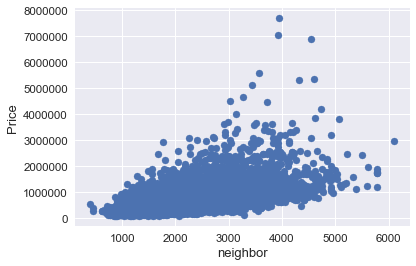

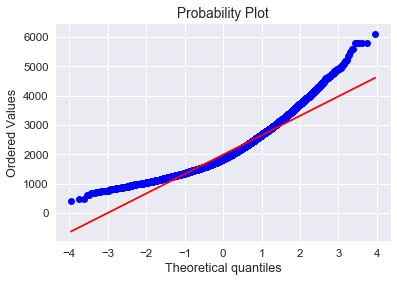

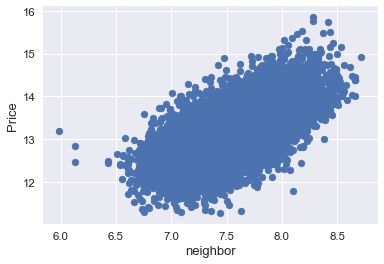

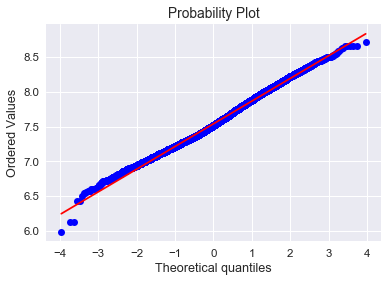

In [18]:
fig, ax = plt.subplots()
ax.scatter(x = df['avg_size_neighbor_houses'], y = df['price'])
plt.ylabel('Price', fontsize=13)
plt.xlabel('neighbor', fontsize=13)
plt.show()

res1 = stats.probplot(df['avg_size_neighbor_houses'], plot=plt)
plt.show()

fig, ax = plt.subplots()
ax.scatter(x = np.log(df['avg_size_neighbor_houses']), y = np.log(df['price']))
plt.ylabel('Price', fontsize=13)
plt.xlabel('neighbor', fontsize=13)
plt.show()

res2 = stats.probplot(np.log(df['avg_size_neighbor_houses']), plot=plt)
plt.show()

#### Embora a aplicação do log resolva facilmente alguns possíveis preblemas de distribuições 'mal comportadas' ele não resolve bem problemas de indices, pois a ideia é de que uma regressão log-log tenha variações constantes, dando a interpretação de 'ao variar nossa endógena em x% a exógena variará em \beta %'

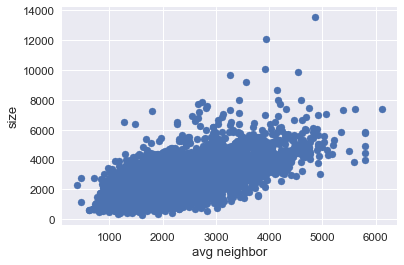

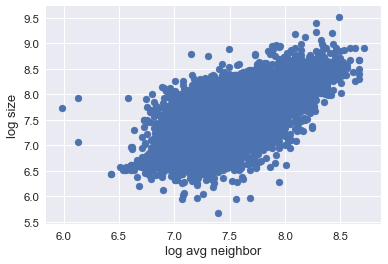

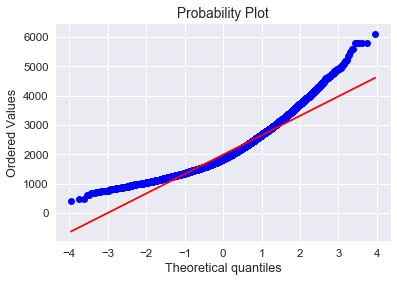

In [19]:
df2 = df.copy(deep=True)
df2['sizediff_relative_of_neighbor'] = (df2['avg_size_neighbor_houses']-df2['size_house'])/df2['size_house']

fig, ax = plt.subplots()
ax.scatter(x = df2['avg_size_neighbor_houses'], y = df2['size_house'])
plt.ylabel('size', fontsize=13)
plt.xlabel('avg neighbor', fontsize=13)
plt.show()

fig, ax = plt.subplots()
ax.scatter(x = np.log(df2['avg_size_neighbor_houses']), y = np.log(df2['size_house']))
plt.ylabel('log size', fontsize=13)
plt.xlabel('log avg neighbor', fontsize=13)
plt.show()

res0 = stats.probplot(df2['avg_size_neighbor_houses'], plot=plt)
plt.show()

#### Relação entre distancia percentual para a média e o Preço de venda
obs: essa variavel não poderá ser usada nas regressões pois um dos inputs é a variavel exógena, usamos para entender a relação da variavel principal.

C:\Users\ABC\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


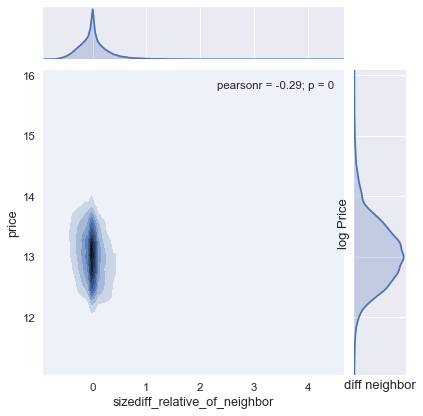

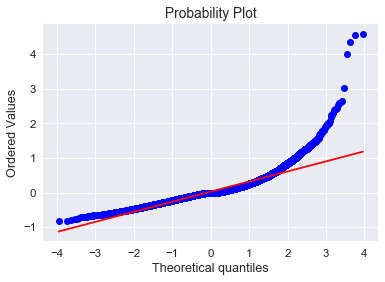

In [20]:
sns.jointplot(df2['sizediff_relative_of_neighbor'], np.log(df2['price']), kind="kde")
plt.ylabel('log Price', fontsize=13)
plt.xlabel('diff neighbor', fontsize=13)
plt.show()

res1 = stats.probplot(df2['sizediff_relative_of_neighbor'], plot=plt)
plt.show()

In [21]:
df2['log_price'] = np.log(df2['price'])
df2['log_size_house'] = np.log(df2['size_house'])
df2['size_lot']
df2['log_size_lot'] = np.log(df2['size_lot'])
df2['log_neighbor_house'] = np.log(df2['avg_size_neighbor_houses'])
df2['log_neighbor_lot'] = np.log(df2['avg_size_neighbor_lot'])
df2['log_size_basement'] = np.log(df2['size_basement'] + 1)

In [22]:
mask1 = (df2['year_built'] != 0)
z_valid = df2[mask1]

df2['time_since_construction'] = 50
df2.loc[mask1, 'time_since_construction'] = np.log(2016 - z_valid['year_built'])

In [23]:
mask2 = (df2['renovation_date'] != 0)
z_valid = df2[mask2]

df2['time_since_renovation'] = 50
df2.loc[mask2, 'time_since_renovation'] = np.log(2016 - z_valid['renovation_date'])

## Variaveis candidatas a Categóricas (classes)

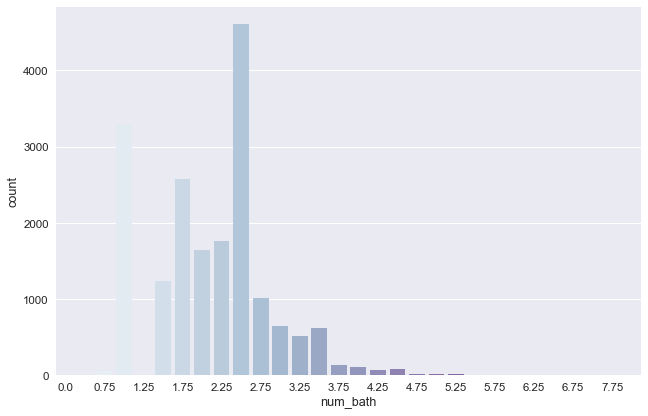

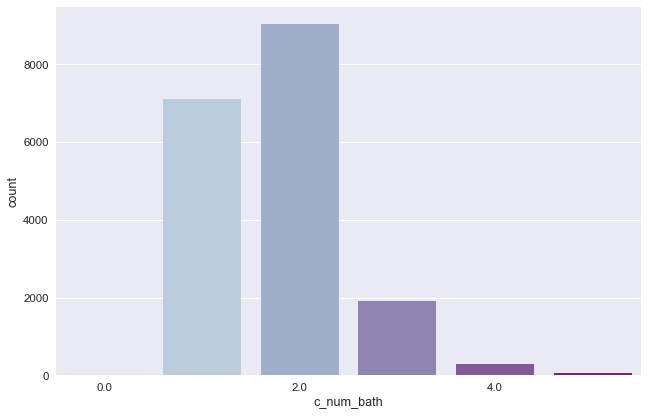

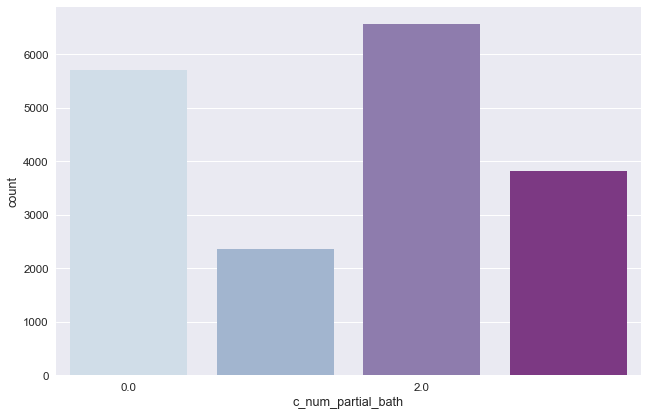

In [24]:
g = sns.factorplot(x="num_bath", data=df2, kind="count",
                   palette="BuPu", size=6, aspect=1.5)
g.set_xticklabels(step=2)

df2['c_num_bath'] = df2.num_bath.replace({0:0, 0.50:0, 0.75:0,
                                          1:1, 1.25:1, 1.50:1, 1.75:1,
                                          2:2, 2.25:2, 2.50:2, 2.75:2,
                                          3:3, 3.25:3, 3.50:3, 3.75:3,
                                          4:4, 4.25:4, 4.50:4, 4.75:4,
                                          5:5, 5.25:5, 5.50:5, 5.75:5,
                                          6:5, 6.25:5, 6.50:5, 6.75:5,
                                          7:5, 7.25:5, 7.50:5, 7.75:5,
                                          8:5})

g = sns.factorplot(x="c_num_bath", data=df2, kind="count",
                   palette="BuPu", size=6, aspect=1.5)
g.set_xticklabels(step=2)

df2['c_num_partial_bath'] = df2.num_bath.replace({0:0, 0.25:1, 0.50:2, 0.75:3,
                                                  1:0, 1.25:1, 1.50:2, 1.75:3,
                                                  2:0, 2.25:1, 2.50:2, 2.75:3,
                                                  3:0, 3.25:1, 3.50:2, 3.75:3,
                                                  4:0, 4.25:1, 4.50:2, 4.75:3,
                                                  5:0, 5.25:1, 5.50:2, 5.75:3,
                                                  6:0, 6.25:1, 6.50:2, 6.75:3,
                                                  7:0, 7.25:1, 7.50:2, 7.75:3,
                                                  8:0})

g = sns.factorplot(x="c_num_partial_bath", data=df2, kind="count",
                   palette="BuPu", size=6, aspect=1.5)
g.set_xticklabels(step=2)

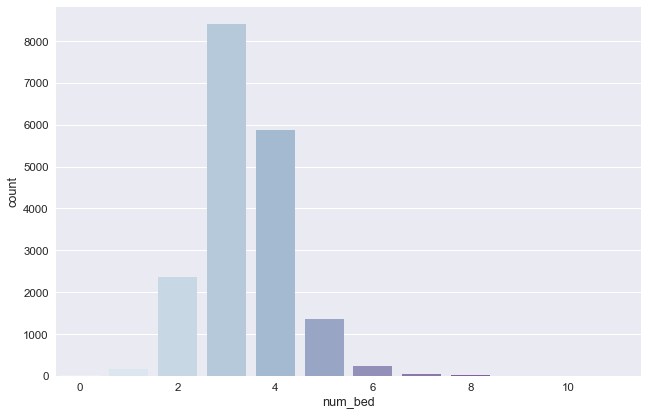

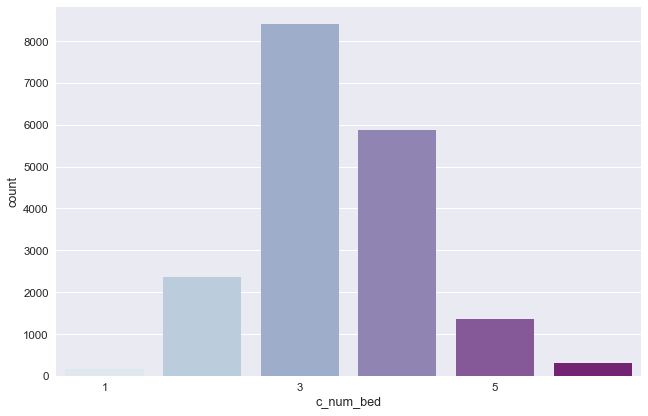

In [25]:
g = sns.factorplot(x="num_bed", data=df2, kind="count",
                   palette="BuPu", size=6, aspect=1.5)
g.set_xticklabels(step=2)

df2['c_num_bed'] = df2.num_bed.replace({ 0:1, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:6, 8:6, 9:6, 10:6, 33:6})

g = sns.factorplot(x="c_num_bed", data=df2, kind="count",
                   palette="BuPu", size=6, aspect=1.5)
g.set_xticklabels(step=2)

In [26]:
df2['c_num_floors'] = df2.num_floors.replace({ 1:1, 1.5:1, 2:2, 2.5:2, 3:3, 3.5:3})
df2['c_num_partial_floors'] = df2.num_floors.replace({ 1:0, 1.5:1, 2:0, 2.5:1, 3:0, 3.5:1})

## Para evitarmos de criar dummies com o zip code que embora aumente o poder explicativo, deixamos os residuos novamente com o terceiro e quarto momentos ainda mais distantes da gaussiana, vamos criar um segundo dataframe com os valores médios agrupados por zip e usar como variaveis endógenas (aceitando a multicolineariedade ... )

In [27]:
# spatial
avg_zip = df2.groupby(df2['zip'])[['price', 'size_house', 'size_lot']].median()
avg_zip.rename(columns={'price': 'zip_price',
                        'size_house': 'zip_size_house',
                        'size_lot':'zip_size_lot'}, inplace=True)

avg_zip = avg_zip.reset_index()
df2 = df2.merge(avg_zip, left_on='zip', right_on='zip', how='inner')

In [28]:
df2['zip_log_price'] = np.log(df2['zip_price'])
df2['zip_log_size_house'] = np.log(df2['zip_size_house'])
df2['zip_log_size_lot'] = np.log(df2['zip_size_lot'])

In [29]:
df2.head()

price  num_bed  num_bath  size_house  size_lot  num_floors  is_waterfront  \
0  221900        3      1.00        1180      5650         1.0              0   
1  205425        2      1.00         880      6780         1.0              0   
2  445000        3      2.25        2100      8201         1.0              0   
3  236000        3      1.00        1300      5898         1.0              0   
4  170000        2      1.00         860      5265         1.0              0   

   condition  size_basement  year_built        ...         c_num_partial_bath  \
0          3              0        1955        ...                        0.0   
1          4              0        1945        ...                        0.0   
2          3            480        1967        ...                        1.0   
3          3              0        1961        ...                        0.0   
4          3              0        1931        ...                        0.0   

   c_num_bed  c_num_floors  c_num_partial_floors  zip_price  zip_size_house  \
0          3           1.0                   0.0   279500.0          1750.0   
1          2           1.0                   0.0   279500.0          1750.0   
2          3           1.0                   0.0   279500.0          1750.0   
3          3           1.0                   0.0   279500.0          1750.0   
4          2           1.0                   0.0   279500.0          1750.0   

   zip_size_lot  zip_log_price  zip_log_size_house  zip_log_size_lot  
0        7227.0      12.540758            7.467371          8.885579  
1        7227.0      12.540758            7.467371          8.885579  
2        7227.0      12.540758            7.467371          8.885579  
3        7227.0      12.540758            7.467371          8.885579  
4        7227.0      12.540758            7.467371          8.885579  

[5 rows x 36 columns]

## Vamos rodar novamente uma OLS simples para ver como as variaveis passaram a se comportar, seus testes conjuntos, assimetria, curtose e R2.

Como evidenciado abaixo, conseguimos tanto aumentar o poder explicativo do modelo sem causar overfiting, além disso diminuimos muito a assimetria dos residuos e embora a curtose não seja baixa ela é 1/6 da inicial!

In [30]:
function2 = '''
log_price ~ sizediff_relative_of_neighbor
 + C(c_num_bed)
 + C(c_num_bath)
 + C(c_num_partial_bath)
 + log_size_house
 + log_size_lot
 + C(c_num_floors)
 + C(is_waterfront)
 + C(condition)
 + log_size_basement
 + time_since_renovation
 + time_since_construction
 + log_neighbor_house
 + log_neighbor_lot
 + np.log(zip_size_house)
 + np.log(zip_price)
 + np.log(zip_size_lot)
'''

model2 = smf.ols(function2, df2).fit()
print(model2.summary2())

                       Results: Ordinary least squares
Model:                   OLS                 Adj. R-squared:        0.864     
Dependent Variable:      log_price           AIC:                   -7867.8610
Date:                    2017-08-27 21:02    BIC:                   -7617.5342
No. Observations:        18448               Log-Likelihood:        3965.9    
Df Model:                31                  F-statistic:           3771.     
Df Residuals:            18416               Prob (F-statistic):    0.00      
R-squared:               0.864               Scale:                 0.038155  
------------------------------------------------------------------------------
                               Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------------------
Intercept                      0.0973   0.0860   1.1310 0.2581 -0.0713  0.2659
C(c_num_bed)[T.2]             -0.0102   0.0164  -0.6191 0.5358 -0.0423  0.02

In [31]:
df2.rename(columns={'condition': 'c_condition', 'is_waterfront':'c_is_waterfront'}, inplace=True)

df3 = df2[['log_price', 'zip', 'latitude', 'longitude', 'sizediff_relative_of_neighbor',
           'log_size_house', 'log_size_lot', 'log_neighbor_house', 'log_neighbor_lot',
           'log_size_basement', 'time_since_construction', 'time_since_renovation',
           'zip_log_size_house', 'zip_log_size_lot', 'zip_log_price','c_condition','c_num_floors',
           'c_num_partial_floors', 'c_num_bath','c_num_partial_bath','c_num_bed', 'c_is_waterfront']]

## As variaveis com maiores e menores correlações com o Preço.

In [32]:
corr = df3.corr()
corr.sort_values(["log_price"], ascending = False, inplace = True)
print(corr.log_price)

log_price                        1.000000
zip_log_price                    0.727163
log_size_house                   0.678255
log_neighbor_house               0.608309
c_num_bath                       0.513889
latitude                         0.451091
zip_log_size_house               0.426187
c_num_bed                        0.354855
c_num_floors                     0.288091
log_size_basement                0.236647
c_is_waterfront                  0.180256
c_num_partial_bath               0.175070
log_size_lot                     0.139005
log_neighbor_lot                 0.124681
c_num_partial_floors             0.069545
longitude                        0.051432
c_condition                      0.038909
zip_log_size_lot                -0.029176
zip                             -0.033795
time_since_renovation           -0.116365
time_since_construction         -0.140814
sizediff_relative_of_neighbor   -0.287990
Name: log_price, dtype: float64


#### Nesse método vamos transformar nossas variaveis categóricas em dummies para permitir que a variação da variavel tenha efeitos diferentes sobre o preço, além de abrir a possibilidade de iterarmos as dummies com as variaveis continuar para flexibilizar o valor dos parametros, ou seja, torna-los condicionais a ter ou não a dummy diferente da regressão comum que considera o efeito ceteris paribus.

In [33]:
categoricals = ['c_condition','c_num_floors','c_num_partial_floors',
                'c_num_bath','c_num_partial_bath','c_num_bed', 'c_is_waterfront', 'zip']

def one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

df3 = one_hot(df3,categoricals)

df3 = df3.drop(categoricals, axis=1)

In [34]:
df3.describe()

log_price      latitude     longitude  \
count  18448.000000  18448.000000  18448.000000   
mean      13.050353     47.560030   -122.214419   
std        0.529053      0.138557      0.139910   
min       11.264464     47.155933   -122.518648   
25%       12.681802     47.471527   -122.328084   
50%       13.017003     47.571599   -122.230688   
75%       13.381646     47.677918   -122.125733   
max       15.856731     47.777624   -121.315254   

       sizediff_relative_of_neighbor  log_size_house  log_size_lot  \
count                   18448.000000    18448.000000  18448.000000   
mean                        0.028938        7.552236      8.987434   
std                         0.312412        0.424779      0.897258   
min                        -0.833333        5.669881      6.253829   
25%                        -0.139876        7.265430      8.527144   
50%                         0.000000        7.560080      8.935969   
75%                         0.134328        7.847763      9.270989   
max                         4.586207        9.513404     14.317109   

       log_neighbor_house  log_neighbor_lot  log_size_basement  \
count        18448.000000      18448.000000       18448.000000   
mean             7.540256          8.957569           2.541691   
std              0.327754          0.805634           3.175123   
min              5.988961          6.478510           0.000000   
25%              7.306531          8.536996           0.000000   
50%              7.517521          8.937350           0.000000   
75%              7.770645          9.215328           6.347389   
max              8.717682         13.662513           8.480737   

       time_since_construction      ...          zip_98146     zip_98148  \
count             18448.000000      ...       18448.000000  18448.000000   
mean                  3.490531      ...           0.013497      0.002602   
std                   0.931502      ...           0.115395      0.050944   
min                   0.000000      ...           0.000000      0.000000   
25%                   2.944439      ...           0.000000      0.000000   
50%                   3.713572      ...           0.000000      0.000000   
75%                   4.158883      ...           0.000000      0.000000   
max                   4.753590      ...           1.000000      1.000000   

          zip_98155     zip_98166     zip_98168     zip_98177     zip_98178  \
count  18448.000000  18448.000000  18448.000000  18448.000000  18448.000000   
mean       0.020382      0.011763      0.012576      0.011925      0.012142   
std        0.141306      0.107820      0.111438      0.108553      0.109524   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

          zip_98188     zip_98198     zip_98199  
count  18448.000000  18448.000000  18448.000000  
mean       0.006071      0.012522      0.014582  
std        0.077683      0.111201      0.119874  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000  
75%        0.000000      0.000000      0.000000  
max        1.000000      1.000000      1.000000  

[8 rows x 112 columns]

# 3) Modelos


Veremos agora alguns modelos bastante simples com suas próprias caracteristicas que podemos testar e combina-los para conseguir tirar o melhor previsor da combinação dos modelos (método de ensemble). 

### Antes de mais nada criamos algumas funções de apoio para medirmos o desempenho desses modelos. 

### Abaixo a função de split que divide nosso dataframe em 2 partes de forma aleatória, uma para treinarmos os modelos e outra para testarmos. É especialmente importante que não usemos os dados de treinamento para testar pois se nosso modelo ficar perfeitamente bom para os dados treinados pode ser que ele não seja genérico o suficiente para ser extrapolado para outros dados, a separação nessa etapa tem esse proposóto

In [35]:
def dfSplit(df,ratio,y='log_price'):
    train, test = train_test_split(df, test_size = ratio)
    y_train = train[y]
    y_test = test[y]
    x_train = train.ix[:, train.columns != y]
    x_test = test.ix[:, test.columns != y]
    return x_train, y_train, x_test, y_test

### Após criar e ajustar diversas variaveis nas etapas anteriores, ainda assim podemos criar polinomios para que nossa função obtenha a flexibilidade de:



### (1) se ajustar a funções quadraticas e principalmente tornar os parametros marginalmente decrescente, ou seja, tem sua primeira derivada positiva e a segunda negativa e 



### (2) permitir interação entre os efeitos, ou seja, será que o efeito do aumento do tamanho da casa se mantém constante quando outras variaveis variam? Acho que não, e podemos testar essas interações criando polinomios multiplicativos.



obs: Essa inserção de parametros multiplicativos não quebra a constistência e robustez da OLS mesmo ela sendo 'linear', pois os parâmetros ajustados (os betas) continuam sendo lineares!

In [36]:
def tPoly(df, degree=1):
    polynomial = PolynomialFeatures(degree=degree)
    return polynomial.fit_transform(df)

## Métricas de ajustes.


#### Diferente das métricas de classificação (precisão, recall, f1-score, etc) as métricas de regressões são um pouco mais complicadas e trabalharemos com as mais simples, a RMSE que tem seus defeitos mas será útil nesse caso e nosso R2.

In [37]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)


def testRegs(df, clf, degree=1, ratio=.2, y='log_price', metrics=[]):

    x_train,y_train,x_test,y_test = dfSplit(df,ratio,y='log_price')

    poly_x_train = tPoly(x_train,degree)
    poly_x_test = tPoly(x_test,degree)

    clf.fit(poly_x_train,y_train)
    
    y_hat = clf.predict(poly_x_test)
    
    rmse = np.sqrt(-cross_val_score(clf, poly_x_train, y_train, scoring = scorer, cv = 10))
    
    print("RMSE:", rmse.mean())
    
    y_train_pred = clf.predict(poly_x_train)
    y_test_pred = clf.predict(poly_x_test)

    print('R2: %.2f, Score: %.2f, Parameters: %i' % (r2_score(y_test, y_hat), 
                                                     clf.score(poly_x_train,y_train), 
                                                     clf.coef_.shape[0]))

    plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
    plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
    plt.show()

    plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
    plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.legend(loc = "upper left")
    plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
    plt.show()

### Regrediremos com OLS os dados sobre diferentes valores polinomias para ter uma noção geral de sobreajuste

RMSE: 0.192132507481
R2: 0.86, Score: 0.87, Parameters: 112


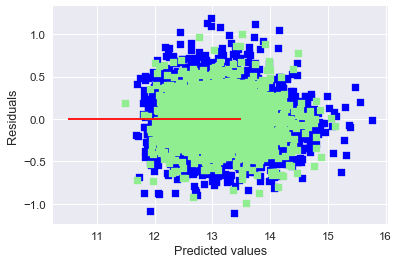

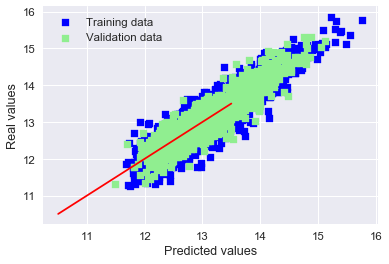

In [38]:
ols_simple = linear_model.LinearRegression()

testRegs(df3,ols_simple,1)

### Como sabemos que nossa base de dados tem bastante multicolinearidade entre os parametros, vamos usar regressões robustas a isso para minimizar esses efeitos de overfiting.

Nessas regressões com regularização, basicamente é adicionado viés aos parâmetros para penalizar os efeitos de valores extremos. Ridge usa L2 e Lasso usa L1.

RMSE: 0.19420895012
R2: 0.88, Score: 0.87, Parameters: 112


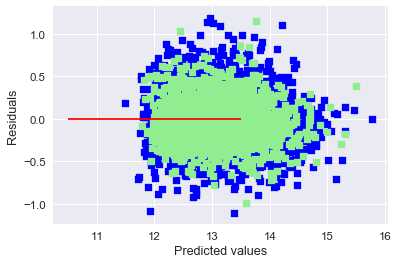

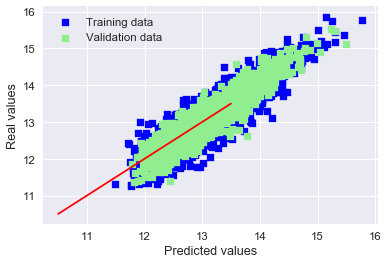

In [39]:
ridge = linear_model.RidgeCV(alphas = [0.001, 0.01, 0.1, 0.5, 0.75, 1, 1.2, 1.5, 2.5, 5])
testRegs(df3,ridge)

RMSE: 0.192824260067
R2: 0.87, Score: 0.87, Parameters: 112


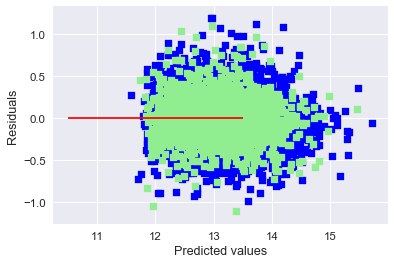

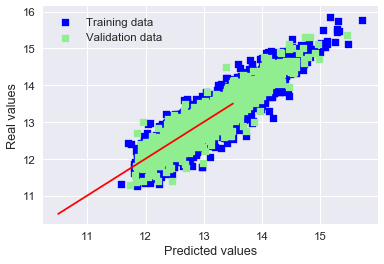

In [40]:
lasso = linear_model.LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003,
                                       0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1],
                                       max_iter = 50000, cv = 10)
testRegs(df3,lasso)

In [42]:
ensemble = ensemble.GradientBoostingRegressor(n_estimators = 500, 
                                              max_depth = 5, 
                                              min_samples_split = 2)

x_train, y_train, x_test, y_test = dfSplit(df3,.1)
gbr = ensemble.fit(x_train, y_train)
print(ensemble.score(x_test, y_test))
print(np.sqrt(-cross_val_score(gbr, x_train, y_train, scoring = scorer, cv = 5)))

0.886167786439
[ 0.16662489  0.18072357  0.17257721  0.17109043  0.17016359]


AttributeError: 'NoneType' object has no attribute 'mean'

# (EM CONSTRUÇÃO)
### Inserindo geolocalização como variaveis autocorrelacionadas endógenas.


C:\Users\ABC\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


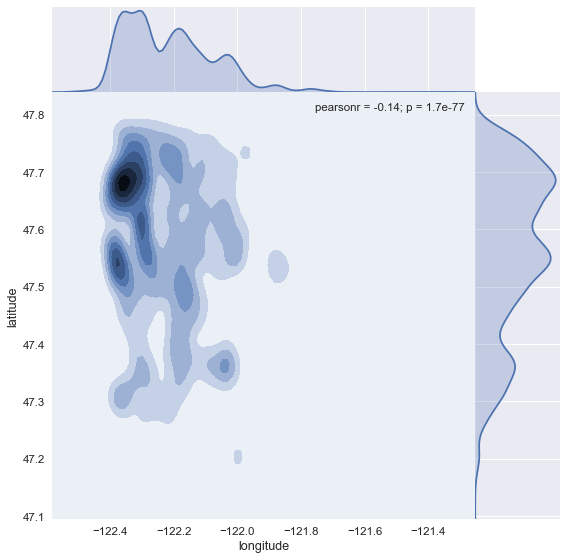

In [43]:
sns.jointplot(x=df.longitude, y=df.latitude, size=8, kind='kde', space=0)

### Uma possibilidade que está bastante na moda é usar Deep learning (nne com camadas ocultas), eu honestamente acho uma ótima ideia para diversos problemas como imagens, sons e outros problemas não linearizaveis, mas o fato de podermos escrever uma função qualquer  não linearizavel quando sabemos que a função deveria ter parâmetros lineares só abre a possibilidade de overfiting desnecesário.

Abaixo alguns casos.

In [47]:
def simple_model():
    model = Sequential()
    model.add(Dense(111, input_dim=111, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [53]:
estimator = KerasRegressor(build_fn=simple_model, nb_epoch=1000000, batch_size=1000, verbose=False)

x_train, y_train, x_test, y_test = dfSplit(df3,.1)

kfold = KFold(n_splits=5)
results = cross_val_score(estimator, x_train.values, y_train, cv=kfold)

In [54]:
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: 0.25 (0.05) MSE


In [63]:
def simple_model_with_hidden():
    model = Sequential()
    model.add(Dense(200, input_dim=111, kernel_initializer='normal', activation='relu'))
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimator = KerasRegressor(build_fn=simple_model_with_hidden, nb_epoch=1000000, batch_size=1000, verbose=False)

x_train, y_train, x_test, y_test = dfSplit(df3,.01)

kfold = KFold(n_splits=5)
results = cross_val_score(estimator, x_train.values, y_train, cv=kfold)

In [64]:
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: 0.26 (0.05) MSE
